# Create Discrete State Space Model. This script estimates the papameter matrices of State Stapce models.

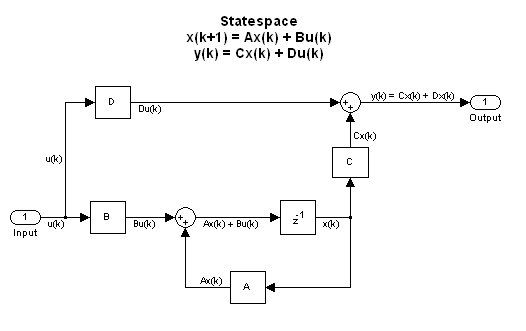

The defined matrices are:
[[-0.2  -0.01]
 [ 0.03  0.  ]]
[[10]
 [ 0]]
[0 1]


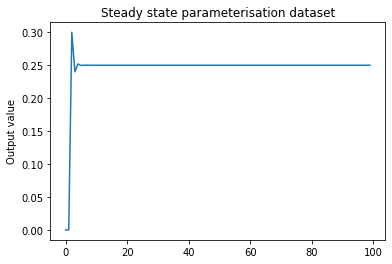

Eigen values of Actual System matrix:  [-0.19848858+0.j -0.00151142+0.j]
Random sampling starts with Iteration 1000
Best initial guess with residual error:  0.01332402745970664
Optimization starts ...
Optimization terminated successfully.
         Current function value: 0.003887
         Iterations: 589
         Function evaluations: 987
Residual error is: 
0.0038868636963222325


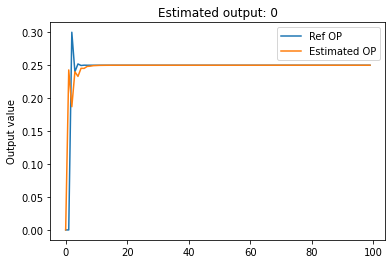

Eigen values of the Estimated System matrix:  [-0.43767247+0.j  0.56734213+0.j]
The estimated matrices are:
[[-0.04369455 -0.15584559]
 [-1.54470177  0.17336421]]
[[0.42932693]
 [1.1598046 ]]
[[-1.4372448   0.74138078]]
Total time elapsed:  1.980647325515747


In [17]:
# Calling libraries
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt

# Creating the class
class cssm :
  def __init__(self, A, B, C, u, y):
      self.A = A
      self.B = B
      self.C = C
      self.u = u
      self.y = y

  # Create the matrices
  def createMat(self, x) :
    # Extract parameters for A matrix
    A1 = x[0 : self.A[0]*self.A[1]]
    # Extract parameters for B matrix
    B1 = x[self.A[0]*self.A[1] : self.A[0]*self.A[1] + self.B[0]*self.B[1]]
    # Extract parameters for C matrix
    C1 = x[self.A[0]*self.A[1] + self.B[0]*self.B[1] : self.A[0]*self.A[1] + self.B[0]*self.B[1] + self.C[0]*self.C[1]]

    # Reshape the matrices
    A1 = np.reshape(A1, (self.A[0], self.A[1])) # No of states X No of states
    B1 = np.reshape(B1, (self.B[0], self.B[1])) # No of states X No of inputs
    C1 = np.reshape(C1, (self.C[0], self.C[1])) # No of outputs X No of states
    return A1, B1, C1

  # Creating the objective function
  def objFcn(self, x, flag = 0) :
    # Get the matrices after reshaping them
    A1, B1, C1 = self.createMat(x)
    
    # Creating initial state as 0
    [r_s, c_s] = np.shape(A1)
    x=np.zeros((r_s,1))

    # For reshaping the input
    [r_s, c_s] = np.shape(B1)

    # Creating a copy of output
    y_p = self.y.copy()
    [r_op, c_op] = np.shape(y_p)

    # Expanding through time
    for i in range(r_op) :
      y_p[i] = np.transpose(np.matmul(C1,x)) # Updating the predicted values
      x = np.matmul(A1,x) + np.matmul(B1,self.u[i].reshape(c_s,1)) #x[k+1]

    # Plotting only the first OP
    if flag == 1:
      [rr, cc] = np.shape(np.matmul(C1,x))
      for iPlot in range(rr) :
        plt.plot(self.y[:,0], label='Ref OP')
        plt.plot(y_p[:,0], label='Estimated OP')
        plt.ylabel('Output value')
        plt.title('Estimated output: ' + str(iPlot))
        plt.legend(loc="upper right")
        plt.show()
      print('Eigen values of the Estimated System matrix: ', linalg.eigvals(A1))

    # Returning the error
    errVal = np.mean(np.abs(y - y_p))
    return(errVal)

  # Initialise function
  def optimizeMdl(self, ite1=100) :
    # Create a placeholder
    totalsizeParams = self.A[0]*self.A[1] + self.B[0]*self.B[1] + self.C[0]*self.C[1]
    valDummy = 1000000000000.00

    # Random sampling
    print('Random sampling starts with Iteration', ite1)
    for iRand in range(ite1):
      # sigma * np.random.randn(...) + mu
      xDummy = np.random.randn(1, totalsizeParams) # sigma = 1 and mu = 1
      xAccpeted = xDummy[0,:]
      if self.objFcn(x = xDummy[0,:]) < valDummy:
        valDummy = self.objFcn(x = xDummy[0,:])
        xAccpeted = xDummy[0,:]
    print('Best initial guess with residual error: ', valDummy)

    # Optimize
    print('Optimization starts ...')
    x0 = xAccpeted
    res = minimize(self.objFcn, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})

    # Final residual error
    print('Residual error is: ')
    print(self.objFcn(x = res.x))

    # Validation : to be edited >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    self.objFcn(x = res.x, flag = 1)

    # Returning the matrices
    return(self.createMat(x = res.x))



# Inital validation of script

# Time on
import time
start = time.time()

# Define the shapes of system matrices as global variables
A = [2,2] # No of states X No of states
B = [2,1] # No of states X No of inputs
C = [1,2] # No of outputs X No of states

# Create dummy data having 100 data points
u = np.ones((100, 1)) # Samples X No of inputs
y = np.ones((100, 1)) # Samples X No of outputs
a_mat = np.array([[-0.2, -0.01],[0.03, 0]])
b_mat = np.array([[10],[0]])
c_mat = np.array([0, 1])
print('The defined matrices are:')
print(a_mat)
print(b_mat)
print(c_mat)
x=np.zeros((2,1))
for i in range(100):
  y[i] = np.matmul(c_mat,x) # Updating the predicted values
  x = np.matmul(a_mat,x) + np.matmul(b_mat,u[i]).reshape(2,1) #x[k+1]
# Show the data
plt.figure()
plt.plot(y)
plt.title('Steady state parameterisation dataset')
plt.ylabel('Output value')
plt.show()
print('Eigen values of Actual System matrix: ', linalg.eigvals(a_mat))
print('=============================================================')

# Creating the model
ssm = cssm(A, B, C, u, y)
A1, B1, C1 = ssm.optimizeMdl(ite1=1000)
print('The estimated matrices are:')
print(A1)
print(B1)
print(C1)

# Time off
end = time.time()
print('Total time elapsed: ', end - start)